<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/Merge/merge_10%20subject_%20without%20new%20subject%20for%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install mne

     |████████████████████████████████| 6.4MB 7.0MB/s 


In [2]:
'''


--->>> Concatenate two cnn model <<<---

* subject number = 10 
[without new subject for test]
 
 
* test acc = 0.9444
* test loss = 0.5521



'''

import matplotlib

from matplotlib import pyplot as plt
import numpy as np

import math

import keras
from keras.utils import to_categorical

import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)





--->>> Merge two cnn model <<<---

* subject number = 10

* test acc = 0.7514
* test loss = 1.8992






In [5]:

subject_number=10
index_new_subject = subject_number//5 #  
train_subject_number = subject_number - index_new_subject
task_index = [1] # task: REO
task_number = len(task_index)


# channels 
list_channel = [60]
ch_number = len(list_channel)

task_time = 60

sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160

inner_sample_shift = 5 # inner step len
outer_sample_shift = 160 # outer step len
window_len= 20

index_new_subject

2

In [6]:
# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index)

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
    for j in range(task_number):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)

Using default location ~/mne_data for EEGBCI...
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  1.2 MB,   1.2 MB/s) /
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   864 kB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) |
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) \
[........................................] 100.00% (  1.2 MB,   1.1 MB/s) -
[........................................] 100.00% (  1.2 MB,   1.1 

In [7]:
# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
test_start_index=subject_img_number - math.floor(subject_img_number * 0.15) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
subject_img_number

59

In [8]:
train_img = np.zeros((train_number*train_subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*train_subject_number, ch_number, window_len + 1, 160), dtype = float)
test_label =[]
new_subject_img = np.zeros((subject_img_number*index_new_subject, ch_number, window_len + 1, 160), dtype = float)

print(" train_img" ,train_img.shape,'\n', "test_img",test_img.shape,'\n', "new_subject_img", new_subject_img.shape)


 train_img (408, 1, 21, 160) 
 test_img (64, 1, 21, 160) 
 new_subject_img (118, 1, 21, 160)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
    ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
    return ch

In [0]:

list_rawdataTest=list_rawdata.copy()


for s in range(subject_number):
    ch_max =[]
    ch_min =[]
    DataChannelsNormal=np.zeros((ch_number,total_sampel_number),dtype = float)
    i =0
    for ch in list_channel:
        DataChannelsRaw, times =list_rawdata[s][0][ch,:total_sampel_number]
      
        # make a copy
        DataChannelsRaw_t=DataChannelsRaw.copy()
        times_t=times.copy()
      
        ch_max = np.append(ch_max, max(DataChannelsRaw_t[0])) # max for each cannel
        ch_min = np.append(ch_min, min(DataChannelsRaw_t[0])) # min for each cannel
      
        # Normalize Channels
        DataChannelsNormal[i]=normalize_channel_data(DataChannelsRaw_t, i, ch_min, ch_max)
        i=i+1
        
    if s < index_new_subject:
        
        for j in range (subject_img_number):
            for i in range(ch_number):
                for z in range (window_len):
              
                    ExtractedData = DataChannelsNormal[i,0+ j*outer_sample_shift + z*inner_sample_shift : sampel_number_per_sec+ j*outer_sample_shift + z*inner_sample_shift]
                    new_subject_img[s*subject_img_number + j][i][z] = ExtractedData
                    if z==window_len-1 :
                        new_subject_img[s*subject_img_number + j][i][z+1] = s
    else:
        
        for j in range (subject_img_number):
            for i in range(ch_number):
                for z in range (window_len):

                    ExtractedData = DataChannelsNormal[i,0+ j*outer_sample_shift + z*inner_sample_shift : sampel_number_per_sec+ j*outer_sample_shift + z*inner_sample_shift]

                    if j <test_start_index :
                        train_img[(s-index_new_subject)* train_number + j][i][z] = ExtractedData
                        if z==window_len-1 :
                            train_img[(s-index_new_subject)*train_number + j][i][z+1] = s


                    else:
                        test_img[(s-index_new_subject)* test_number + j - test_start_index][i][z] = ExtractedData
                        if z==window_len-1 :
                            test_img[(s-index_new_subject)*test_number + j - test_start_index][i][z+1] = s
                            
           # if j >=test_start_index :
               # test_label = np.append(test_label, (s))



In [0]:
#shaffle train img array
train_img_shuffle = train_img.copy()

np.random.shuffle(train_img_shuffle)

In [12]:
#create train input1 & input2
len_train_img = len(train_img)
trian_input_number = int(math.factorial(len_train_img) / (2 * math.factorial(len_train_img-2)))
print(trian_input_number)

input1 = np.zeros((trian_input_number, ch_number, window_len + 1, 160), dtype = float)
input2 = np.zeros((trian_input_number, ch_number, window_len + 1, 160), dtype = float)


83028


In [0]:
# fill input train img 1 ,2
n=0
for i in range(len_train_img):
  index1 = train_img_shuffle[0]
  
  train_img_shuffle = np.delete(train_img_shuffle, 0, axis=0)
  
  input1[n: n + len(train_img_shuffle)] = train_img_shuffle
  input2[n: n + len(train_img_shuffle)] = index1
  n =   n + len(train_img_shuffle) 

del train_img_shuffle

In [0]:
train_label=[]
# create train label array
for i in range(trian_input_number):
  if input1[i][0][window_len][0] == input2[i][0][window_len][0]:
    train_label = np.append(train_label, 1)
  else:
    train_label = np.append(train_label, 0)
  #print(i)
    
    
    

In [0]:
# remove label row 
input1_2 = np.zeros((trian_input_number, ch_number, window_len, 160), dtype = float)
input2_2 = np.zeros((trian_input_number, ch_number, window_len, 160), dtype = float)
  
  

In [0]:
def remove_label(input_number, inputx, inputx_2 ):
  
  for i in range(input_number) :

    for j in range (ch_number):

      inputx_2[i][j] = np.delete(inputx[i][j], window_len, axis=0)
    
  return (inputx_2)

In [17]:
input1_2 = remove_label(trian_input_number, input1, input1_2)
input2_2 = remove_label(trian_input_number, input2, input2_2)

input2_2.shape


(83028, 1, 20, 160)

In [20]:
###############################  test ##################################
# create total test img (part of train img + new subject img)
#total_test_img = np.concatenate((test_img, new_subject_img))
total_test_img = test_img


total_test_img.shape


(64, 1, 21, 160)

In [21]:

# create 2 input test image
len_test_img = len(total_test_img)
test_input_number = int(math.factorial(len_test_img) / (2 * math.factorial(len_test_img-2)))
print(test_input_number)

input1_test = np.zeros((test_input_number, ch_number, window_len + 1, 160), dtype = float)
input2_test = np.zeros((test_input_number, ch_number, window_len + 1, 160), dtype = float)


2016


In [0]:


# fill input test img 1 ,2
n=0
for i in range(len_test_img):
  index1 = total_test_img[0]
  total_test_img = np.delete(total_test_img, 0, axis=0)
  
  input1_test[n: n + len(total_test_img)] = total_test_img
  input2_test[n: n + len(total_test_img)] = index1
  n =   n + len(total_test_img) 

#del input2_test


In [0]:

test_label=[]
# create test label array
for i in range(test_input_number):
  if input1_test[i][0][window_len][0] == input2_test[i][0][window_len][0]:
    test_label = np.append(test_label, 1)
    #print(test_label)
  else:
    test_label = np.append(test_label, 0)


In [0]:
    
# remove label row 

input1_test_2 = np.zeros((test_input_number, ch_number, window_len, 160), dtype = float)
input2_test_2 = np.zeros((test_input_number, ch_number, window_len, 160), dtype = float)



In [25]:
input1_test_2 = remove_label(test_input_number, input1_test, input1_test_2)
input2_test_2 = remove_label(test_input_number, input2_test, input2_test_2)

input2_test_2.shape


(2016, 1, 20, 160)

In [0]:
test_label[:1000]



In [28]:
# categorical test & train label
train_label = to_categorical(train_label, 2)
test_label = to_categorical(test_label, 2)
train_label

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
validation_index = math.floor( trian_input_number * 0.2)


# validation & train

#train
x_train_1 =input1_2[validation_index:]
x_train_2 =input2_2[validation_index:]

y_train =train_label[validation_index:]

#validation
x_validation_1 =input1_2[:validation_index]
x_validation_2 =input2_2[:validation_index] 

y_valid =train_label[:validation_index]

#x_valid.shape

In [30]:

from keras import layers
from keras import models
from keras import regularizers
#from keras.layers import Dense, Merge
from keras.layers import *
from keras.models import Model


cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
print(cnn1.output.shape)
cnn1.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn1.output.shape)
cnn1.add(layers.MaxPooling2D((2,2)))
cnn1.add(layers.Flatten())
print(cnn1.output.shape)


cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
print(cnn2.output.shape)
cnn2.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(cnn2.output.shape)
cnn2.add(layers.MaxPooling2D((2,2)))
cnn2.add(layers.Flatten())
print(cnn2.output.shape)

mergedOut = Concatenate()([cnn1.output,cnn2.output])

#mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(512, activation='relu')(mergedOut)
mergedOut = Dropout(.5)(mergedOut)

# output layer
mergedOut = Dense(2, activation='sigmoid')(mergedOut)

newModel = Model([cnn1.input,cnn2.input], mergedOut)

#model = models.Sequential()
#model.add(layers.Concatenate([cnn1,cnn2]))
#model.add(layers.Dense(512, activation = 'relu'))
#model.add(layers.Dropout(0.5))
#print(model.output.shape)
#model.add(layers.Dense(2, activation = 'sigmoid'))
#print(model.output.shape)


from keras import optimizers

newModel.compile(loss= 'binary_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])






(?, 64, 20, 160)

(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
history = newModel.fit(
        [x_train_1, x_train_2],
        y_train,
        epochs = 20,
        batch_size = 20,
        validation_data = ([x_validation_1, x_validation_2], y_valid)
)

Train on 66423 samples, validate on 16605 samples
Epoch 1/20
66423/66423 [==============================] - 94s 1ms/step - loss: 0.3807 - acc: 0.8771 - val_loss: 0.3771 - val_acc: 0.8773
Epoch 2/20
66423/66423 [==============================] - 90s 1ms/step - loss: 0.3587 - acc: 0.8800 - val_loss: 0.2517 - val_acc: 0.8944
Epoch 3/20
66423/66423 [==============================] - 90s 1ms/step - loss: 0.1618 - acc: 0.9163 - val_loss: 0.1108 - val_acc: 0.9482
Epoch 4/20
66423/66423 [==============================] - 90s 1ms/step - loss: 0.0911 - acc: 0.9543 - val_loss: 0.1494 - val_acc: 0.9263
Epoch 5/20
66423/66423 [==============================] - 91s 1ms/step - loss: 0.0451 - acc: 0.9830 - val_loss: 0.0921 - val_acc: 0.9542
Epoch 6/20
66423/66423 [==============================] - 90s 1ms/step - loss: 0.0172 - acc: 0.9953 - val_loss: 0.0698 - val_acc: 0.9731
Epoch 7/20
66423/66423 [==============================] - 90s 1ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.1054 - val_acc

In [32]:
newModel.evaluate([input1_test_2, input2_test_2], test_label)


2016/2016 [==============================] - 1s 421us/step


[0.552116695487963, 0.9444444444444444]

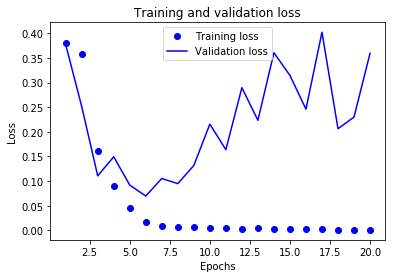

In [33]:
import matplotlib.pyplot as plt

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

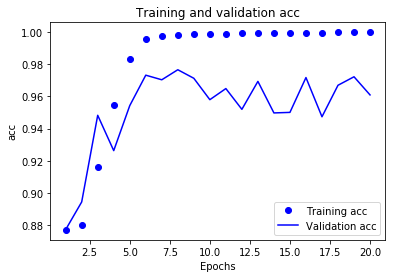

In [34]:
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()